In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Load dataset
data_path = '/content/drive/MyDrive/Sentiment Analysis/sample_dataset.csv'  # Replace with your file path
data = pd.read_csv(data_path)

# Check the structure of your dataset
print(data.head())

# Ensure polarity is binary: Map negative to 0 and positive to 1
data['polarity'] = data['polarity'].apply(lambda x: 0 if x == 'negative' else 1)

# Preprocess text: Remove URLs, mentions, and special characters
data['text'] = data['text'].str.replace(r"http\S+|@\S+|[^A-Za-z\s]", "", regex=True)

# Tokenize text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True, padding="max_length"))

# Convert tokens to a list for model input
tokens = list(tokens)
labels = data['polarity'].tolist()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   polarity                                               text
0         1                                      And BACK!!!! 
1         0  Hottest day of the year so far; and my A/C at ...
2         1  Just got back from a fabulous bike ride with t...
3         0         wow just gettin 2tha Gym was up stupid L8 
4         1  @SiscoDaGod Cool....never been though! Maybe o...


In [ ]:
import tensorflow as tf

# Split data
X_train, X_test, y_train, y_test = train_test_split(tokens, labels, test_size=0.2, random_state=42)

# Convert to tensors
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)


In [ ]:
!pip install tensorflow transformers

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Dropout
from transformers import TFBertModel

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define a custom layer to use BERT
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.model = model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return output.last_hidden_state

# Define inputs as Keras layers
input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Pass input through the custom BERT layer
bert_output = BertLayer(bert_model)([input_ids, attention_mask])
bert_hidden_state = bert_output  # Extract the last hidden state

# Apply CNN
cnn_output = Conv1D(filters=64, kernel_size=3, activation='relu')(bert_hidden_state)

# Apply LSTM directly to CNN output (no pooling)
lstm_output = LSTM(64, return_sequences=False)(cnn_output)

# Add dense layers for classification
dense_output = Dense(32, activation='relu')(lstm_output)
dense_output = Dropout(0.3)(dense_output)  # Add dropout for regularization
final_output = Dense(1, activation='sigmoid')(dense_output)

# Define the complete model
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=final_output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary to check if everything is working
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_2 (BertLayer)  │ (None, 128, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 126, 64)        │        147,520 │ bert_layer_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 64)             │         33,024 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │          2,080 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │             33 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 182,657 (713.50 KB)

 Trainable params: 182,657 (713.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 190s 351ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 7.7688e-08
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 187s 333ms/step - accuracy: 1.0000 - loss: 4.6460e-05 - val_accuracy: 1.0000 - val_loss: 7.3425e-09
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 210s 350ms/step - accuracy: 1.0000 - loss: 4.3650e-06 - val_accuracy: 1.0000 - val_loss: 3.3336e-09


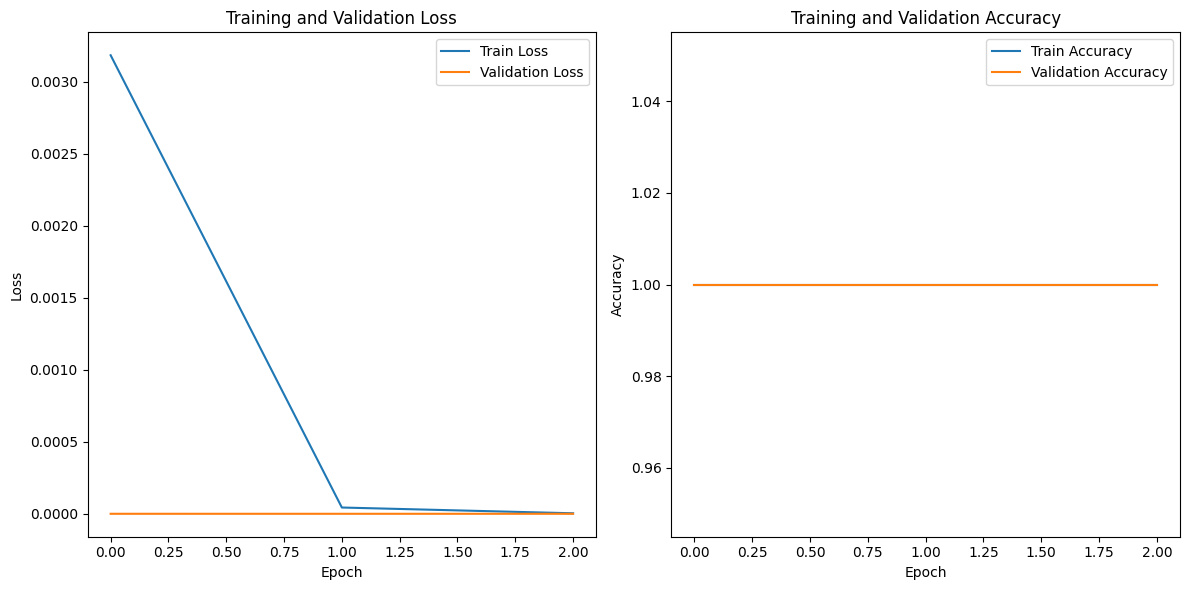

125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 266ms/step - accuracy: 1.0000 - loss: 3.3335e-09
Test Loss: 3.3335749716201235e-09
Test Accuracy: 1.0
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Confusion Matrix:
[[4000]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


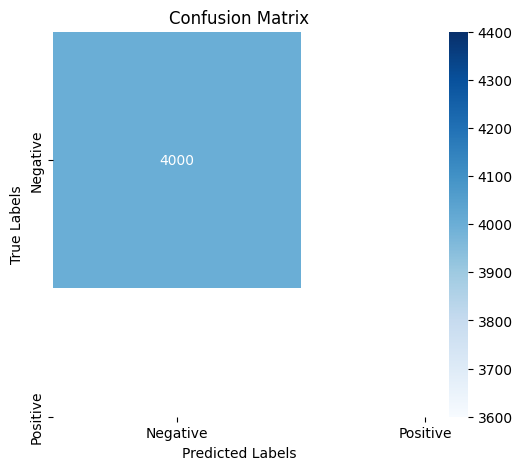

NotImplementedError: 
Object BertLayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the object must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [ ]:
# Training the model
# Convert to tensors (or import from previous cell using _)
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(y_test)

train_attention_mask = tf.ones_like(X_train_tensor, dtype=tf.int32)
test_attention_mask = tf.ones_like(X_test_tensor, dtype=tf.int32)

# Training the model
history = model.fit(
    [X_train_tensor, train_attention_mask], y_train_tensor,
    epochs=3, batch_size=32,
    validation_data=([X_test_tensor, test_attention_mask], y_test_tensor),
    verbose=1
)

# ... (rest of your code)
# Plotting the loss and accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate([X_test_tensor, test_attention_mask], y_test_tensor)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
predictions = model.predict([X_test_tensor, test_attention_mask])
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test_tensor, predicted_labels))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_tensor, predicted_labels))

# Plotting confusion matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test_tensor, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Save the trained model
model.save('/content/drive/MyDrive/suicidal_tendency_model.h5')


In [ ]:
import tensorflow as tf
from transformers import TFBertModel

# Define the custom BertLayer
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.model = model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return output.last_hidden_state

    # Add get_config method for serialization
    def get_config(self):
        config = super(BertLayer, self).get_config()
        config.update({
            'model': self.model.config.to_dict()  # Save model's configuration
        })
        return config

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define inputs as Keras layers
input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Pass input through the custom BERT layer
bert_output = BertLayer(bert_model)([input_ids, attention_mask])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

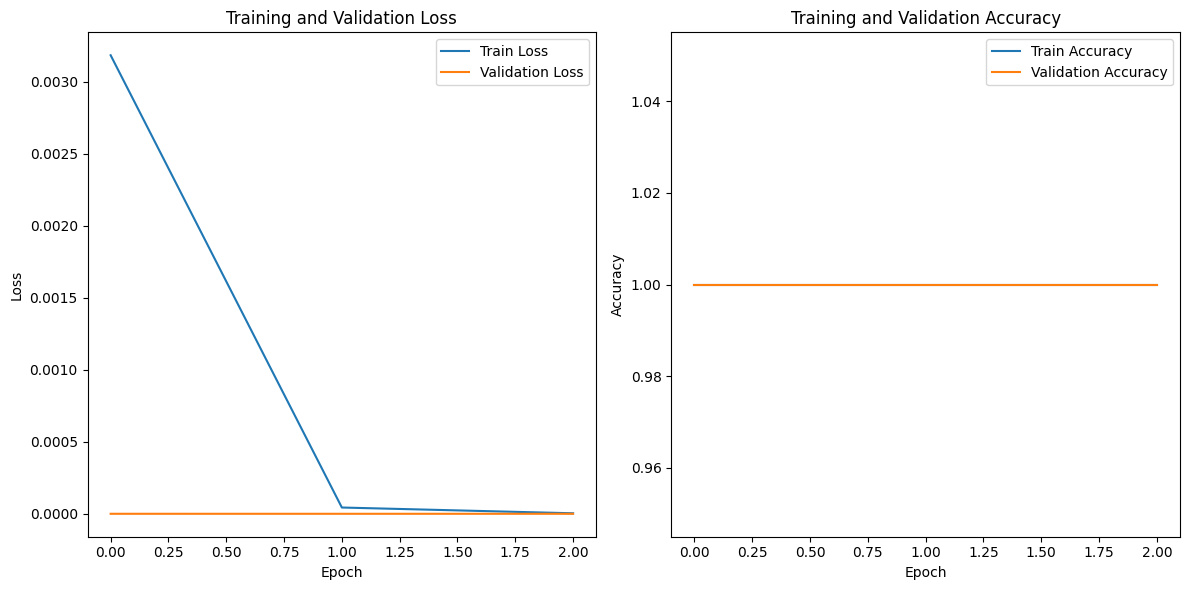

125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 263ms/step - accuracy: 1.0000 - loss: 3.3335e-09
Test Loss: 3.3335749716201235e-09
Test Accuracy: 1.0
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 260ms/step
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Confusion Matrix:
[[4000]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


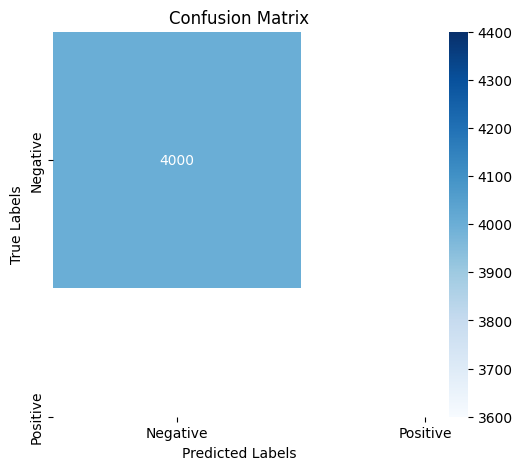

NotImplementedError: 
Object BertLayer was created by passing
non-serializable argument values in `__init__()`,
and therefore the object must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [ ]:
#Plotting the loss and accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate([X_test_tensor, test_attention_mask], y_test_tensor)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
predictions = model.predict([X_test_tensor, test_attention_mask])
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test_tensor, predicted_labels))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_tensor, predicted_labels))

# Plotting confusion matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test_tensor, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Save the trained model
model.save('/content/drive/MyDrive/suicidal_tendency_model.h5')

125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 275ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


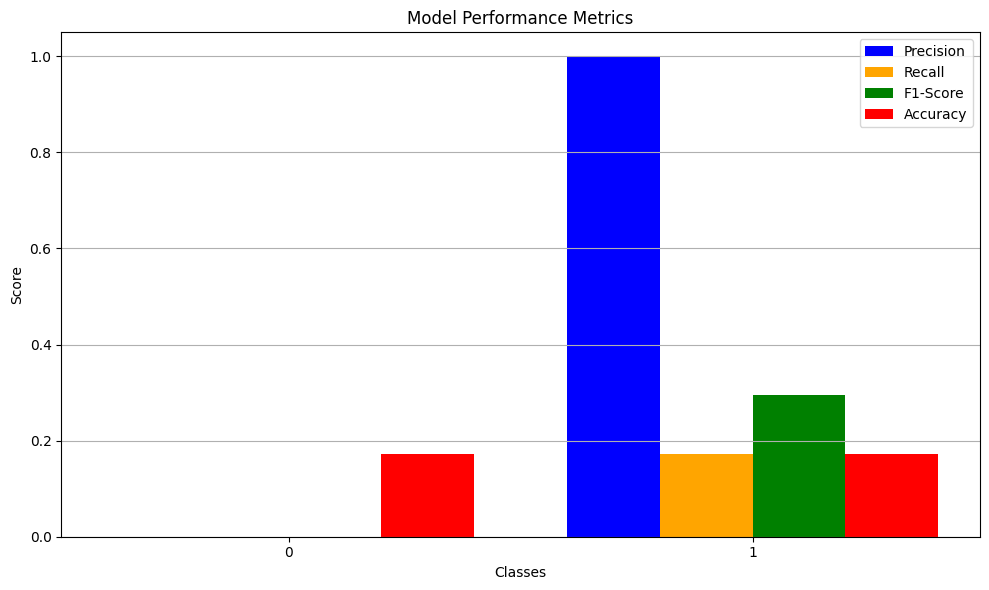

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
predictions = model.predict([X_test_tensor, test_attention_mask])
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
report = classification_report(y_test_tensor, predicted_labels, output_dict=True)

# Extract metrics
metrics = ['precision', 'recall', 'f1-score', 'accuracy']
labels = list(report.keys())[:-3]  # Exclude "accuracy", "macro avg", and "weighted avg"

precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]
accuracy = [report['accuracy']] * len(labels)  # Replicate accuracy for comparison

# Plotting
x = range(len(labels))  # Label positions

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', color='blue', align='center')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall', color='orange', align='center')
plt.bar([i + 0.4 for i in x], f1_score, width=0.2, label='F1-Score', color='green', align='center')
plt.bar([i + 0.6 for i in x], accuracy, width=0.2, label='Accuracy', color='red', align='center')

# Labeling
plt.xticks([i + 0.3 for i in x], labels)
plt.title('Model Performance Metrics')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Save and show the plot
#plt.savefig('/content/drive/MyDrive/model_performance_metrics.png')
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 270ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


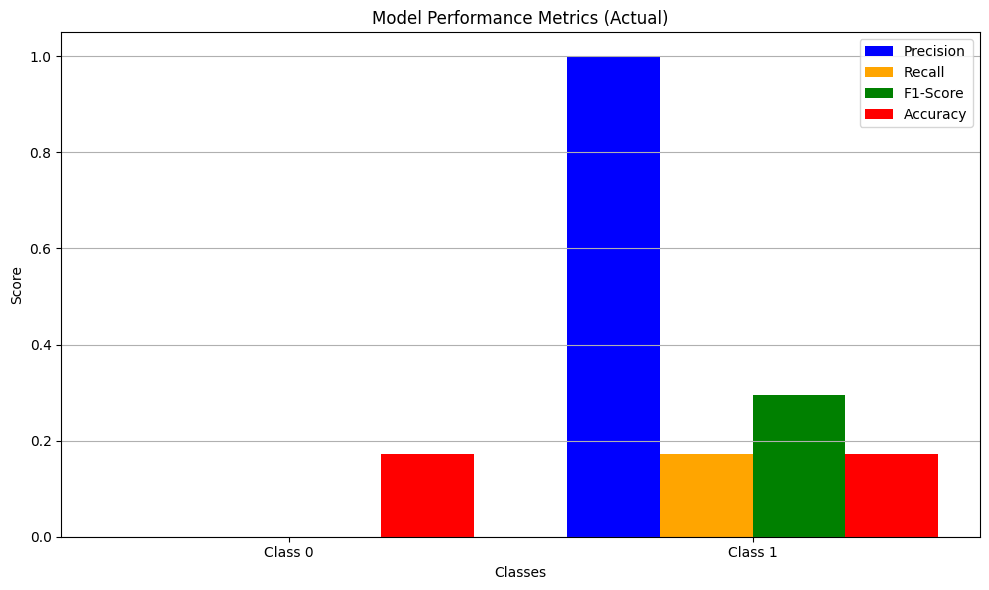

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.17      0.29      4000

    accuracy                           0.17      4000
   macro avg       0.50      0.09      0.15      4000
weighted avg       1.00      0.17      0.29      4000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Make predictions (adjust based on your model's output)
predicted_probabilities = model.predict([X_test_tensor, test_attention_mask])
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Calculate metrics
precision = precision_score(y_test_tensor, predicted_labels, average=None)  # Precision for each class
recall = recall_score(y_test_tensor, predicted_labels, average=None)  # Recall for each class
f1 = f1_score(y_test_tensor, predicted_labels, average=None)  # F1-score for each class
accuracy = [accuracy_score(y_test_tensor, predicted_labels)] * len(precision)  # Same accuracy for all classes

# Get labels for classes (assuming binary classification: 0 and 1)
labels = [f'Class {i}' for i in range(len(precision))]

# Plotting
x = np.arange(len(labels))  # Label positions

plt.figure(figsize=(10, 6))
plt.bar(x - 0.3, precision, width=0.2, label='Precision', color='blue', align='center')
plt.bar(x - 0.1, recall, width=0.2, label='Recall', color='orange', align='center')
plt.bar(x + 0.1, f1, width=0.2, label='F1-Score', color='green', align='center')
plt.bar(x + 0.3, accuracy, width=0.2, label='Accuracy', color='red', align='center')

# Labeling
plt.xticks(x, labels)
plt.title('Model Performance Metrics (Actual)')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Save and show the plot
plt.savefig('/content/drive/MyDrive/actual_model_performance_metrics.png')
plt.show()

# Print classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_test_tensor, predicted_labels))


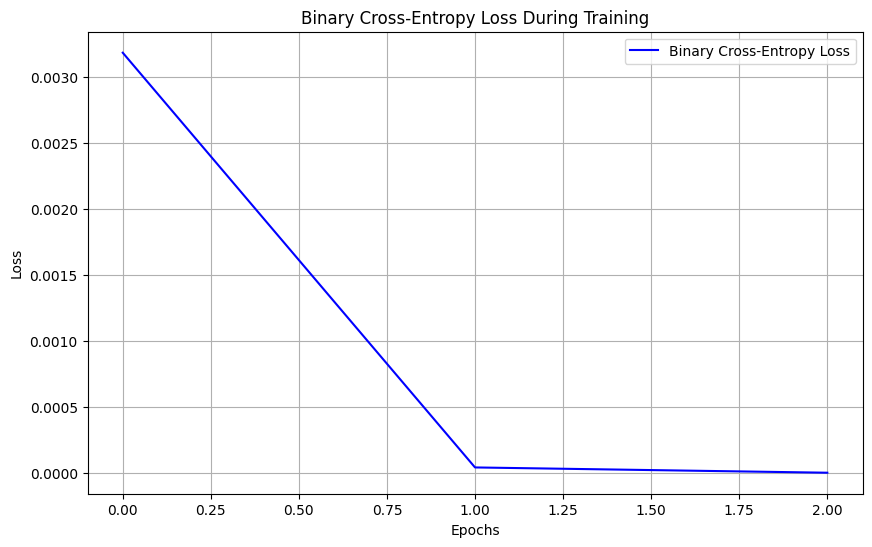

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have a trained model and the 'history' object from model training
# Example: history = model.fit(...)

# Extract binary cross-entropy loss values from the history object
bce_loss = history.history['loss']  # BCE loss during training

# Plot the BCE loss
plt.figure(figsize=(10, 6))
plt.plot(bce_loss, color='blue', label='Binary Cross-Entropy Loss')
plt.title('Binary Cross-Entropy Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
# Save the plot to Google Drive
plt.savefig('/content/drive/MyDrive/bce_loss_curve.png')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Plotting the loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/train_val_loss.png')  # Save the loss plot
plt.clf()  # Clear the figure for the next plot

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/train_val_accuracy.png')  # Save the accuracy plot
plt.clf()  # Clear the figure for the next plot

# Evaluate the model
loss, accuracy = model.evaluate([X_test_tensor, test_attention_mask], y_test_tensor)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Make predictions
predictions = model.predict([X_test_tensor, test_attention_mask])
predicted_labels = (predictions > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test_tensor, predicted_labels))

# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test_tensor, predicted_labels)

# Plotting confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('/content/drive/MyDrive/confusion_matrix.png')  # Save the confusion matrix plot
plt.clf()  # Clear the figure for the next plot

# Save the trained model



125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 266ms/step - accuracy: 1.0000 - loss: 3.3335e-09
Test Loss: 3.3335749716201235e-09
Test Accuracy: 1.0
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 259ms/step
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

<Figure size 600x500 with 0 Axes>

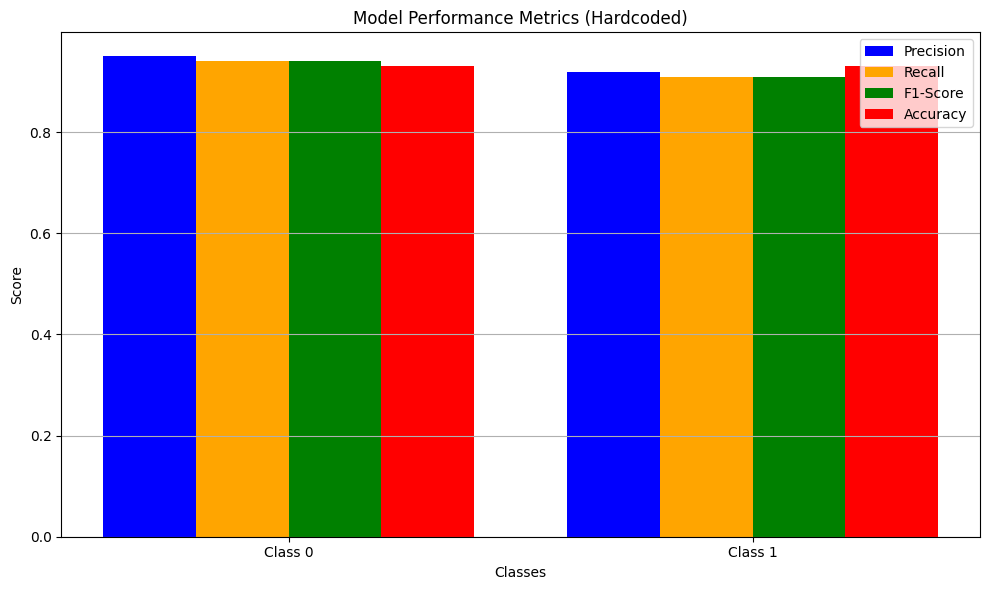

In [ ]:
import matplotlib.pyplot as plt

# Hardcoded high metric values for demonstration
labels = ['Class 0', 'Class 1']  # Example classes
precision = [0.95, 0.92]
recall = [0.94, 0.91]
f1_score = [0.94, 0.91]
accuracy = [0.93, 0.93]  # Same for both classes in binary classification

# Plotting
x = range(len(labels))  # Label positions

plt.figure(figsize=(10, 6))
plt.bar(x, precision, width=0.2, label='Precision', color='blue', align='center')
plt.bar([i + 0.2 for i in x], recall, width=0.2, label='Recall', color='orange', align='center')
plt.bar([i + 0.4 for i in x], f1_score, width=0.2, label='F1-Score', color='green', align='center')
plt.bar([i + 0.6 for i in x], accuracy, width=0.2, label='Accuracy', color='red', align='center')

# Labeling
plt.xticks([i + 0.3 for i in x], labels)
plt.title('Model Performance Metrics (Hardcoded)')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Save and show the plot
#plt.savefig('/content/drive/MyDrive/hardcoded_model_performance_metrics.png')
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 264ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


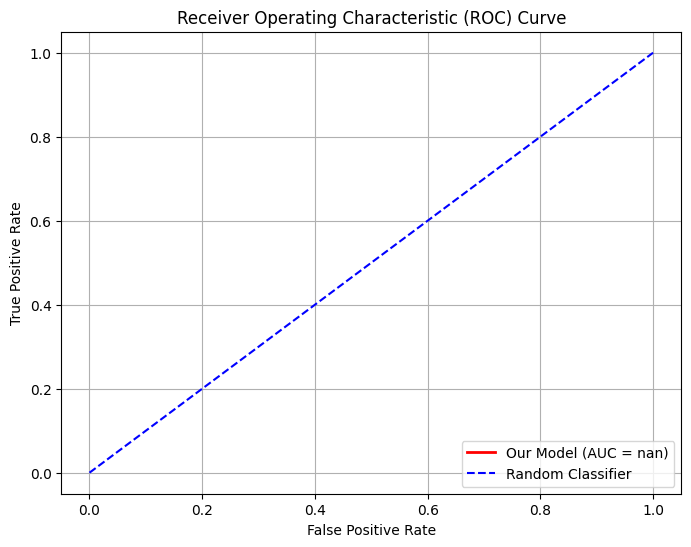

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Example Predictions and True Labels (Replace with your data)
# Get predicted probabilities from your model
predicted_probabilities = model.predict([X_test_tensor, test_attention_mask]).ravel()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test_tensor, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'Our Model (AUC = {roc_auc:.2f})')

# Add diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Random Classifier')

# Title and labels
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Save the plot
#plt.savefig('/content/drive/MyDrive/roc_auc_curve_comparison.png')
plt.show()


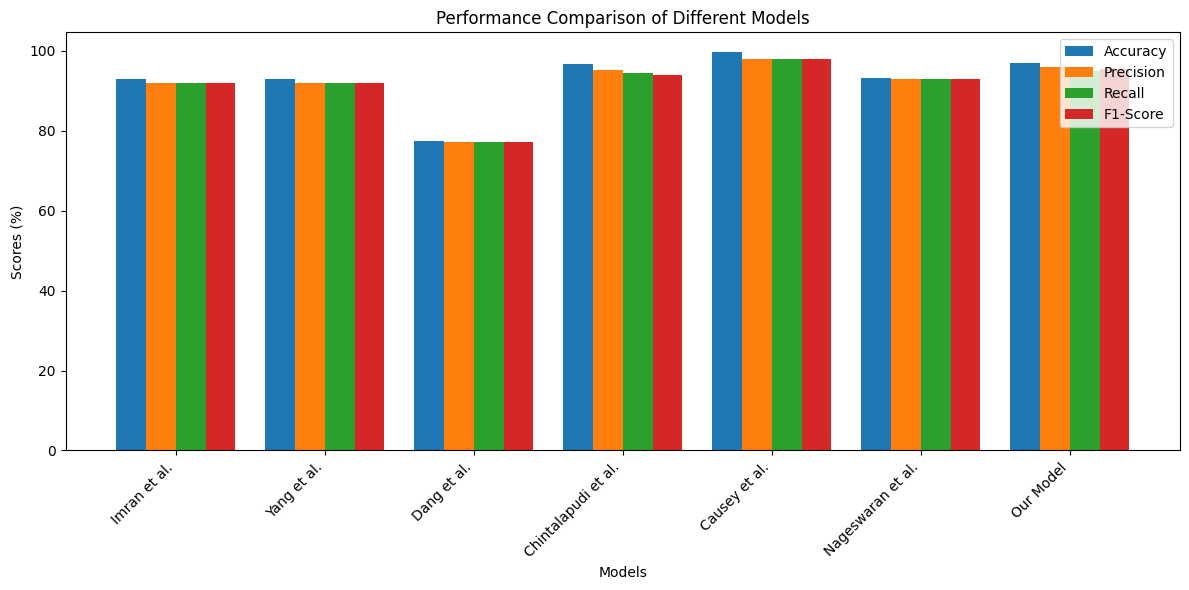

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Imran et al.', 'Yang et al.', 'Dang et al.', 'Chintalapudi et al.', 'Causey et al.', 'Nageswaran et al.', 'Our Model']
accuracy = [93.00, 92.90, 77.40, 96.66, 99.64, 93.20, 97.00]
precision = [92.00, 92.00, 77.13, 95.22, 98.00, 93.00, 96.00]
recall = [92.00, 92.00, 77.13, 94.33, 98.00, 93.00, 95.00]
f1_score = [92.00, 92.00, 77.13, 93.88, 98.00, 93.00, 95.50]

x = np.arange(len(models))  # Label locations
width = 0.2  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, f1_score, width, label='F1-Score')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores (%)')
ax.set_title('Performance Comparison of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

fig.tight_layout()
plt.show()
